In [11]:
import torch
import torch.nn.functional as F
from torch import nn
import torchvision
import tqdm
import numpy
import matplotlib.pyplot as plt
from torchvision.transforms import v2


In [3]:
from torchvision.transforms import ToTensor

### Q7

In [4]:
data_root = 'data'
batch_size = 16

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
print(f"Using device {device}")

Using device cuda:0


In [55]:
train = torchvision.datasets.MNIST(root=data_root, train=True,\
download=True, transform=ToTensor())
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,\
shuffle=True, num_workers=2)

test = torchvision.datasets.MNIST(root=data_root, train=False,\
download=True, transform=ToTensor())
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size,\
shuffle=True, num_workers=2)

In [7]:
len(trainloader), len(testloader)

(3750, 625)

In [79]:
train_data = []
train_labels = []

for data, labels in trainloader:
    train_data.append(data)
    train_labels.append(labels)
    
train_data = torch.cat(train_data)
train_labels = torch.cat(train_labels)
    

test_data = []
test_labels = []
for data, labels in testloader:
    test_data.append(data)
    test_labels.append(labels)

test_data = torch.cat(test_data)
test_labels = torch.cat(test_labels)

train_data, val_data = train_data[:50000], train_data[50000:]
train_labels, val_labels = train_labels[:50000], train_labels[50000:]

In [80]:
len(train_data), len(val_data)

(50000, 10000)

In [81]:
import numpy as np

In [82]:
np.bincount(train_labels.numpy()) / len(train_labels), np.bincount(val_labels.numpy()) / len(val_labels)

(array([0.09822, 0.113  , 0.09858, 0.10226, 0.0972 , 0.09004, 0.09902,
        0.10404, 0.09858, 0.09906]),
 array([0.1012, 0.1092, 0.1029, 0.1018, 0.0982, 0.0919, 0.0967, 0.1063,
        0.0922, 0.0996]))

In [83]:
import torch.nn.functional as F

In [104]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 3 * 3, 10)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    

In [136]:
model = Model()
model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [137]:
import tqdm

In [138]:
criterion(torch.tensor([[0.1, 0.2, 0.3]]), torch.tensor([2]))

tensor(1.0019)

In [139]:
model.train()

Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=10, bias=True)
)

In [140]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}
for epoch in tqdm.tqdm(range(6), leave=True):
    avg_loss = 0
    pbar = tqdm.tqdm(range(0, len(train_data), batch_size), position=0)
    for bn in pbar:
        data = train_data[bn:bn+batch_size].to(device)
        labels = train_labels[bn:bn+batch_size].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        
        loss = criterion(outputs, labels)
        
        if bn % 300 == 0:
            pbar.set_description(f"loss: {loss.item():.4f}")
        
        loss.backward()
        
        optimizer.step()
        
        avg_loss += loss.item()
    history["train_loss"].append(avg_loss / len(train_data))
    
    with torch.no_grad():
        avg_loss = 0
        correct = 0
        for bn in range(0, len(val_data), batch_size):
            data = val_data[bn:bn+batch_size].to(device)
            labels = val_labels[bn:bn+batch_size].to(device)
            
            outputs = model(data)
            
            loss = criterion(outputs, labels)
            
            avg_loss += loss.item()
            
            correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
        history["val_acc"].append(correct / len(val_data))
        history["val_loss"].append(avg_loss / len(val_data))
    
        
        

100%|██████████| 6/6 [00:49<00:00,  8.23s/it]


In [141]:
# get train accuracy
with torch.no_grad():
    correct = 0
    for bn in range(0, len(train_data), batch_size):
        data = train_data[bn:bn+batch_size].to(device)
        labels = train_labels[bn:bn+batch_size].to(device)

        outputs = model(data)

        correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
print(f"Train accuracy: {correct / len(train_data)}")

Train accuracy: 0.98914


In [142]:
# get val accuracy
with torch.no_grad():
    val_outputs = model(val_data.to(device))
    val_loss = criterion(val_outputs, val_labels.to(device))
    val_preds = torch.argmax(val_outputs, dim=1)
    val_acc = (val_preds == val_labels.to(device)).float().mean()
    print(f"Val accuracy: {val_acc.item()}")

Val accuracy: 0.9878999590873718


In [143]:
#eval on test 
with torch.no_grad():
    test_outputs = model(test_data.to(device))
    test_loss = criterion(test_outputs, test_labels.to(device))
    test_preds = torch.argmax(test_outputs, dim=1)
    test_acc = (test_preds == test_labels.to(device)).float().mean()
    print(f"Test accuracy: {test_acc.item()}")

Test accuracy: 0.9872999787330627


In [125]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Epoch')

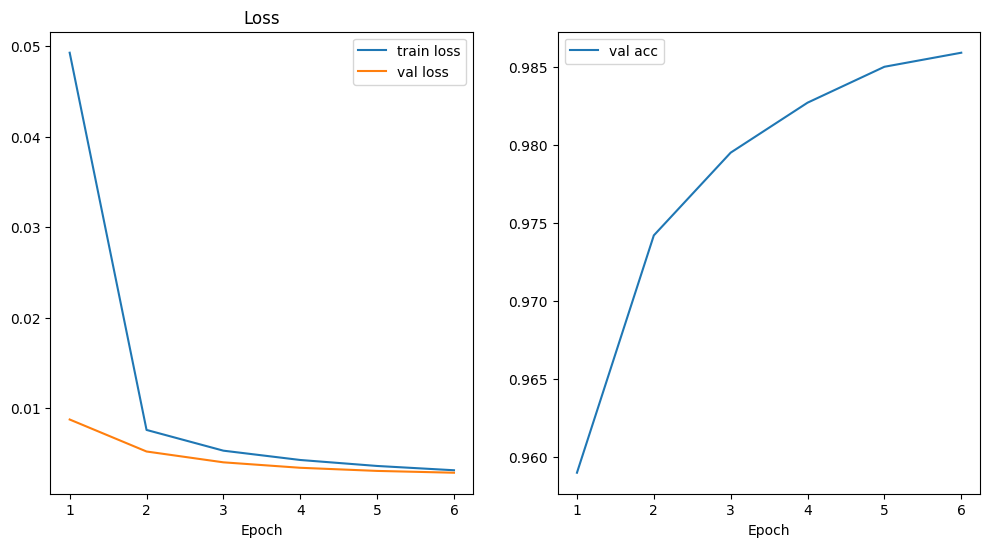

In [126]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history["train_loss"])+1), history["train_loss"], label="train loss")
plt.plot(range(1, len(history["train_loss"])+1), history["val_loss"], label="val loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.subplot(1, 2, 2)
# plt.plot(range(1, len(history)+1), history["train_acc"], label="train acc")
plt.plot(range(1, len(history["train_loss"])+1), history["val_acc"], label="val acc")
plt.legend()
plt.xlabel("Epoch")

### Q8

In [129]:
transforms = v2.Compose([
    v2.RandomResizedCrop(28, scale=(0.8, 1.0), antialias=False),
    v2.RandomRotation(10),
])

In [130]:
model = Model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [131]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}
for epoch in tqdm.tqdm(range(6), leave=True):
    avg_loss = 0
    pbar = tqdm.tqdm(range(0, len(train_data), batch_size), position=0)
    for bn in pbar:
        data = transforms(train_data[bn:bn+batch_size].to(device))
        labels = train_labels[bn:bn+batch_size].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data)
        
        loss = criterion(outputs, labels)
        
        if bn % 300 == 0:
            pbar.set_description(f"loss: {loss.item():.4f}")
        
        loss.backward()
        
        optimizer.step()
        
        avg_loss += loss.item()
    history["train_loss"].append(avg_loss / len(train_data))
    
    with torch.no_grad():
        avg_loss = 0
        correct = 0
        for bn in range(0, len(val_data), batch_size):
            data = val_data[bn:bn+batch_size].to(device)
            labels = val_labels[bn:bn+batch_size].to(device)
            
            outputs = model(data)
            
            loss = criterion(outputs, labels)
            
            avg_loss += loss.item()
            
            correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
        history["val_acc"].append(correct / len(val_data))
        history["val_loss"].append(avg_loss / len(val_data))

  0%|          | 0/3125 [00:00<?, ?it/s]/home/am/miniconda3/envs/vudl/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 6/6 [01:39<00:00, 16.56s/it]


In [132]:
# get train accuracy
with torch.no_grad():
    correct = 0
    for bn in range(0, len(train_data), batch_size):
        data = train_data[bn:bn+batch_size].to(device)
        labels = train_labels[bn:bn+batch_size].to(device)

        outputs = model(data)

        correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
print(f"Train accuracy: {correct / len(train_data)}")

Train accuracy: 0.99152


In [133]:
# get val accuracy
with torch.no_grad():
    val_outputs = model(val_data.to(device))
    val_loss = criterion(val_outputs, val_labels.to(device))
    val_preds = torch.argmax(val_outputs, dim=1)
    val_acc = (val_preds == val_labels.to(device)).float().mean()
    print(f"Val accuracy: {val_acc.item()}")

Val accuracy: 0.9899999499320984


Text(0.5, 0, 'Epoch')

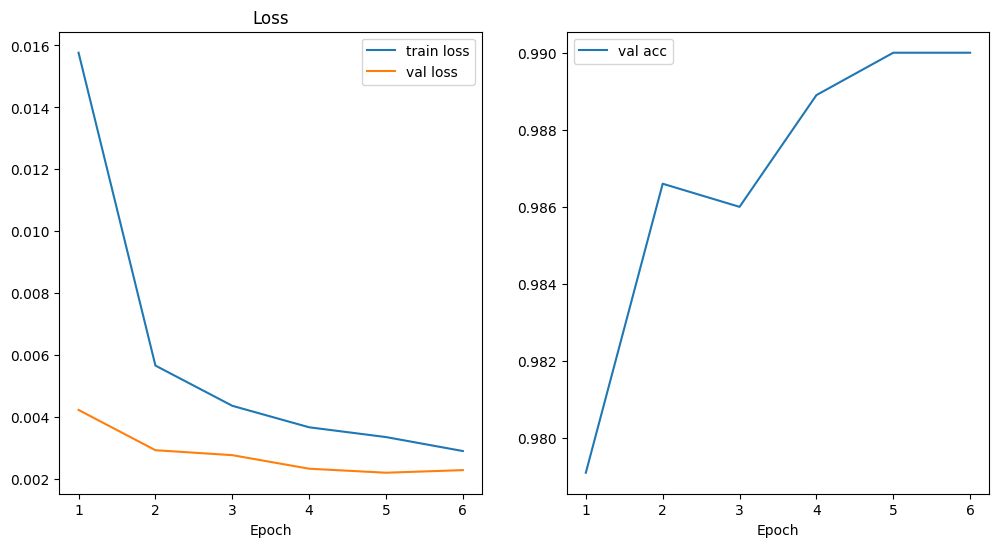

In [134]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history["train_loss"])+1), history["train_loss"], label="train loss")
plt.plot(range(1, len(history["train_loss"])+1), history["val_loss"], label="val loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.subplot(1, 2, 2)
# plt.plot(range(1, len(history)+1), history["train_acc"], label="train acc")
plt.plot(range(1, len(history["train_loss"])+1), history["val_acc"], label="val acc")
plt.legend()
plt.xlabel("Epoch")

In [135]:
# eavluating on test set
with torch.no_grad():
    test_outputs = model(test_data.to(device))
    test_loss = criterion(test_outputs, test_labels.to(device))
    test_preds = torch.argmax(test_outputs, dim=1)
    test_acc = (test_preds == test_labels.to(device)).float().mean()
    print(f"Test accuracy: {test_acc.item()}")

Test accuracy: 0.9896000027656555


### Q 12

In [144]:
!wget https://dlvu.github.io/data/mnist-varres.tgz

--2023-12-09 23:43:46--  https://dlvu.github.io/data/mnist-varres.tgz
Resolving dlvu.github.io (dlvu.github.io)... 185.199.110.153, 185.199.111.153, 185.199.109.153, ...
Connecting to dlvu.github.io (dlvu.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17536487 (17M) [application/octet-stream]
Saving to: ‘mnist-varres.tgz’

mnist-varres.tgz    100%[===================>]  16.72M  10.9MB/s    in 1.5s    

2023-12-09 23:43:51 (10.9 MB/s) - ‘mnist-varres.tgz’ saved [17536487/17536487]



In [146]:
!tar -xzf mnist-varres.tgz

In [149]:
transforms = v2.Compose([
    v2.Resize((28, 28)),
    v2.ToTensor(),
    # drop channels 2 and 3
    v2.Lambda(lambda x: x[0:1]),
])

/home/am/miniconda3/envs/vudl/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [150]:
trainloader = torchvision.datasets.ImageFolder("mnist-varres/train", transform=transforms)
testloader = torchvision.datasets.ImageFolder("mnist-varres/test", transform=transforms)

In [151]:
# split into train and val 
train_data, val_data = torch.utils.data.random_split(trainloader, [50000, 10000])

In [152]:
train_data

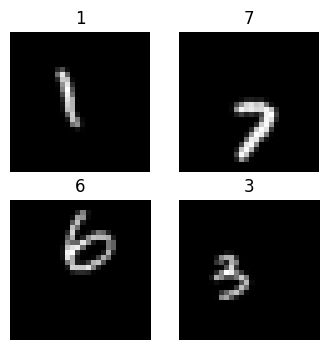

In [153]:
# visualize 4 images
plt.figure(figsize=(4, 4))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(train_data[i][0][0], cmap="gray")
    plt.title(train_data[i][1])
    plt.axis("off")

In [154]:
model = Model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [155]:
# get batch out of train_data
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,\
shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,\
shuffle=True, num_workers=2)

In [156]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}
for epoch in tqdm.tqdm(range(6), leave=True):
    avg_loss = 0
    pbar = tqdm.tqdm(trainloader, position=0)
    for data, labels in pbar:
        # data = train_data[bn:bn+batch_size][0].to(device)
        # labels = train_data[bn:bn+batch_size][1].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(data.to(device))
        
        loss = criterion(outputs, labels.to(device))
        
        # if bn % 300 == 0:
        #     pbar.set_description(f"loss: {loss.item():.4f}")
        
        loss.backward()
        
        optimizer.step()
        
        avg_loss += loss.item()
    history["train_loss"].append(avg_loss / len(train_data))
    
    with torch.no_grad():
        avg_loss = 0
        correct = 0
        for data, labels in valloader:
            # data = val_data[bn:bn+batch_size][0].to(device)
            # labels = val_data[bn:bn+batch_size][1].to(device)
            
            outputs = model(data.to(device))
            labels = labels.to(device)
            
            loss = criterion(outputs, labels)
            
            avg_loss += loss.item()
            
            correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
            
        history["val_acc"].append(correct / len(val_data))
        history["val_loss"].append(avg_loss / len(val_data))

100%|██████████| 6/6 [02:37<00:00, 26.31s/it]


In [157]:
# eval on train
with torch.no_grad():
    correct = 0
    for data, labels in trainloader:
        # data = train_data[bn:bn+batch_size][0].to(device)
        # labels = train_data[bn:bn+batch_size][1].to(device)

        outputs = model(data.to(device))

        correct += (torch.argmax(outputs, dim=1) == labels.to(device)).sum().item()

In [158]:
print(f"Train accuracy: {correct / len(train_data)}")

Train accuracy: 0.9838


In [159]:
# eval on val
with torch.no_grad():
    correct = 0
    for data, labels in valloader:
        # data = val_data[bn:bn+batch_size][0].to(device)
        # labels = val_data[bn:bn+batch_size][1].to(device)

        outputs = model(data.to(device))

        correct += (torch.argmax(outputs, dim=1) == labels.to(device)).sum().item()
        

In [160]:
print(f"Val accuracy: {correct / len(val_data)}")

Val accuracy: 0.967


In [161]:
# evaluate test accuracy
testloader = torch.utils.data.DataLoader(testloader, batch_size=batch_size,\
shuffle=True, num_workers=2)
with torch.no_grad():
    correct = 0
    for data, labels in testloader:
        # data = test_data[bn:bn+batch_size][0].to(device)
        # labels = test_data[bn:bn+batch_size][1].to(device)

        outputs = model(data.to(device))

        correct += (torch.argmax(outputs, dim=1) == labels.to(device)).sum().item()
        
print(f"Test accuracy: {correct / len(testloader.dataset)}")

Test accuracy: 0.9713


Text(0.5, 0, 'Epoch')

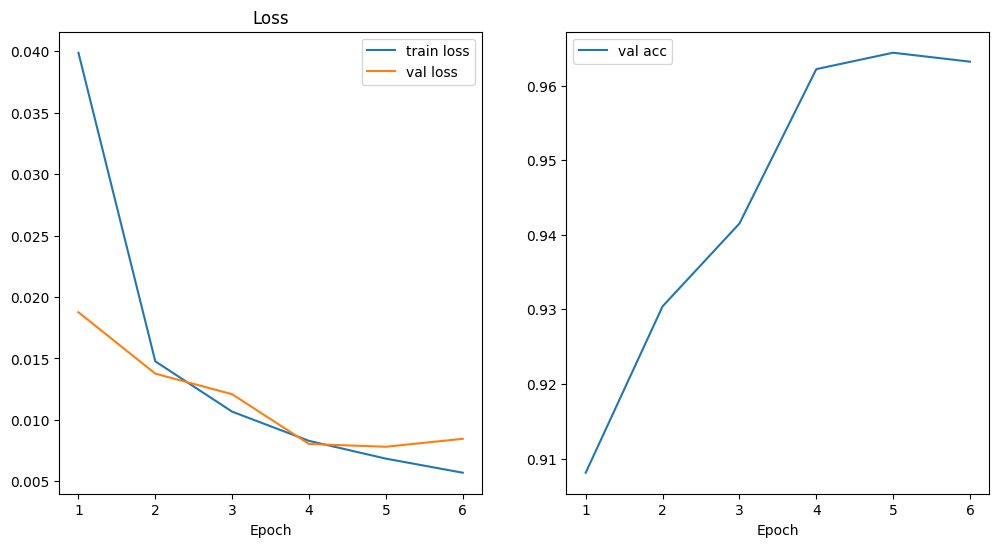

In [243]:
# plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history["train_loss"])+1), history["train_loss"], label="train loss")
plt.plot(range(1, len(history["train_loss"])+1), history["val_loss"], label="val loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.subplot(1, 2, 2)
# plt.plot(range(1, len(history)+1), history["train_acc"], label="train acc")
plt.plot(range(1, len(history["train_loss"])+1), history["val_acc"], label="val acc")
plt.legend()
plt.xlabel("Epoch")

### Q14-17

In [140]:
transforms = v2.Compose([
    # v2.Resize((28, 28)),
    v2.ToTensor(),
    # drop channels 2 and 3
    # v2.Lambda(lambda x: x[0:1]),
])

/home/am/miniconda3/envs/vudl/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [335]:
class SpecificSizeImageFolder(torchvision.datasets.ImageFolder):
    def __init__(self, root, transform=None, target_size=(224, 224)):
        super().__init__(root, transform)
        self.target_size = target_size
        self.filtered_indices = self._filter()
        
    def _filter(self):
        filtered_indices = []
        last_dim = []
        for i in tqdm.tqdm(range(len(self)), desc="Filtering"):
            path, _ = self.samples[i]
            img = self.loader(path)
            
            if img.size[-1] == self.target_size[-1]:
                filtered_indices.append(i)
                
        return filtered_indices
    
    def __getitem__(self, index):
        filtered_index = self.filtered_indices[index]
        return super().__getitem__(filtered_index)
    
    def __len__(self):
        # check if has attribute filtered_indices
        if hasattr(self, "filtered_indices"):
            return len(self.filtered_indices)
        
        return super().__len__()

In [293]:
trainloader32 = SpecificSizeImageFolder("mnist-varres/train", transform=transforms, target_size=(32, 32))
trainloader48 = SpecificSizeImageFolder("mnist-varres/train", transform=transforms, target_size=(48, 48))
trainloader64 = SpecificSizeImageFolder("mnist-varres/train", transform=transforms, target_size=(64, 64))

testloader64 = SpecificSizeImageFolder("mnist-varres/test", transform=transforms, target_size=(64, 64))
testloader48 = SpecificSizeImageFolder("mnist-varres/test", transform=transforms, target_size=(48, 48))
testloader32 = SpecificSizeImageFolder("mnist-varres/test", transform=transforms, target_size=(32, 32))

Filtering: 100%|██████████| 10000/10000 [00:00<00:00, 13694.42it/s]


In [13]:
import glob

In [14]:
from PIL import Image

In [15]:
import sklearn

In [16]:
def load_crap(folder):
    crap = [
        [] for _ in range(3)
    ]
    labels = [
        [] for _ in range(3)
    ]
    
    for label in tqdm.tqdm(glob.glob(f"{folder}/*")):
        for img_path in glob.glob(f"{label}/*"):
            img = transforms(Image.open(img_path))
            if img.shape[-1] == 32:
                crap[0].append(img)
                labels[0].append(int(label[-1]))
            elif img.shape[-1] == 48:
                crap[1].append(img)
                labels[1].append(int(label[-1]))
            elif img.shape[-1] == 64:
                crap[2].append(img)
                labels[2].append(int(label[-1]))
                
    # shuffle each list
    for i in range(3):
        crap[i] = torch.stack(crap[i])
        labels[i] = torch.tensor(labels[i])
        crap[i], labels[i] = sklearn.utils.shuffle(crap[i], labels[i])
    
    return crap, labels

In [17]:
train = load_crap("mnist-varres/train")
test = load_crap("mnist-varres/test")

100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


In [18]:
[ len(tt) for tt in train ], [ len(tt) for tt in test ]

([3, 3], [3, 3])

(array([904.,  17.,   9.,   9.,  13.,   4.,   9.,   4.,   6.,  49.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

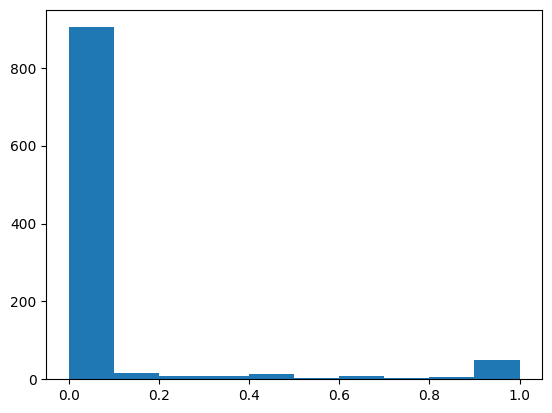

In [311]:
plt.hist(train[0][0].ravel())

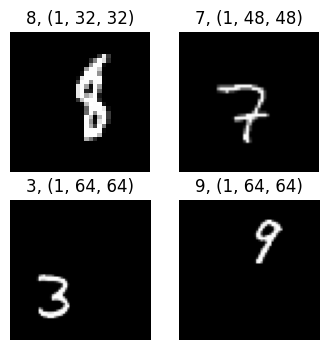

In [255]:
# visualize 4 images
plt.figure(figsize=(4, 4))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(train_data[i][0][0], cmap="gray")
    plt.title(f"{train_data[i][1]}, {train_data[i][0].numpy().shape}")
    plt.axis("off")

In [353]:
train[1][2].shape

torch.Size([20007])

In [141]:
class MultiModel(nn.Module):
    # inspired by https://stackoverflow.com/questions/74726927/adjustment-of-cnn-architecture-when-size-of-input-image-is-changed
    def __init__(self, N=64):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3,3), padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, N, kernel_size=(3,3), padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        # self.adaptivepool = nn.AdaptiveMaxPool2d((1,1))
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(N, 10)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        # x = F.relu(self.conv3(x))
        # x = F.adaptive_max_pool2d(x, (64 * 3 * 3))
        x = self.adaptivepool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [142]:
# multi_model = MultiModel(N=82)
multi_model = MultiModel()
multi_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(multi_model.parameters(), lr=0.001)

In [143]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}
for epoch in tqdm.tqdm(range(6), leave=True):
    avg_loss = 0
    for train_size in range(3):
        pbar = tqdm.tqdm(range(0, int(len(train[0][train_size]) * (1-.16)), batch_size), position=0)
        for bn in pbar:
            data = train[0][train_size][bn:bn+batch_size].to(device)
            labels = train[1][train_size][bn:bn+batch_size].to(device)
            
            optimizer.zero_grad()
            
            outputs = multi_model(data)
            
            # print(outputs, labels)
            
            loss = criterion(outputs, labels)
            
            if bn % 300 == 0:
                pbar.set_description(f"loss: {loss.item():.4f}")
            
            loss.backward()
            
            optimizer.step()
            
            avg_loss += loss.item()
            
    history["train_loss"].append(avg_loss / (60_000 * (1 - .16)//batch_size ) )
    
    with torch.no_grad():
        avg_loss = 0
        correct = 0
        for val_size in range(3):
            for bn in range(int(len(train[0][val_size]) * (1-.16)), len(train[0][val_size]), batch_size):
                data = train[0][val_size][bn:bn+batch_size].to(device)
                labels = train[1][val_size][bn:bn+batch_size].to(device)
                
                outputs = multi_model(data)
                
                loss = criterion(outputs, labels)
                
                avg_loss += loss.item()
                
                correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
            
        history["val_acc"].append(correct / (60_000 * (.16)))
        history["val_loss"].append(avg_loss / (60_000 * (.16)))

100%|██████████| 6/6 [01:07<00:00, 11.22s/it]


In [144]:
# get train accuracy
with torch.no_grad():
    correct = 0
    for train_size in range(3):
        for bn in range(0, int(len(train[0][train_size])//batch_size * (1-.16)),):
            data = train[0][train_size][bn:bn+batch_size].to(device)
            labels = train[1][train_size][bn:bn+batch_size].to(device)

            outputs = multi_model(data)

            correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
            
print(f"Train accuracy: {correct / (60_000 * (1 - .16))}")

Train accuracy: 0.9816269841269841


In [145]:
# get val accuracy
with torch.no_grad():
    correct = 0
    for val_size in range(3):
        for bn in range(int(len(train[0][val_size]) * (1-.16)), len(train[0][val_size]), batch_size):
            data = train[0][val_size][bn:bn+batch_size].to(device)
            labels = train[1][val_size][bn:bn+batch_size].to(device)

            outputs = multi_model(data)

            correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
print(f"Val accuracy: {correct / (60_000 * (.16))}")

Val accuracy: 0.9735416666666666


In [148]:
# eval on test
with torch.no_grad():
    correct = 0
    for test_size in range(3):
        for bn in range(0, len(test[0][test_size]), batch_size):
            data = test[0][test_size][bn:bn+batch_size].to(device)
            labels = test[1][test_size][bn:bn+batch_size].to(device)

            outputs = multi_model(data)

            correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
print(f"Test accuracy: {correct / (10_000)}")

Test accuracy: 0.9758


Text(0.5, 0, 'Epoch')

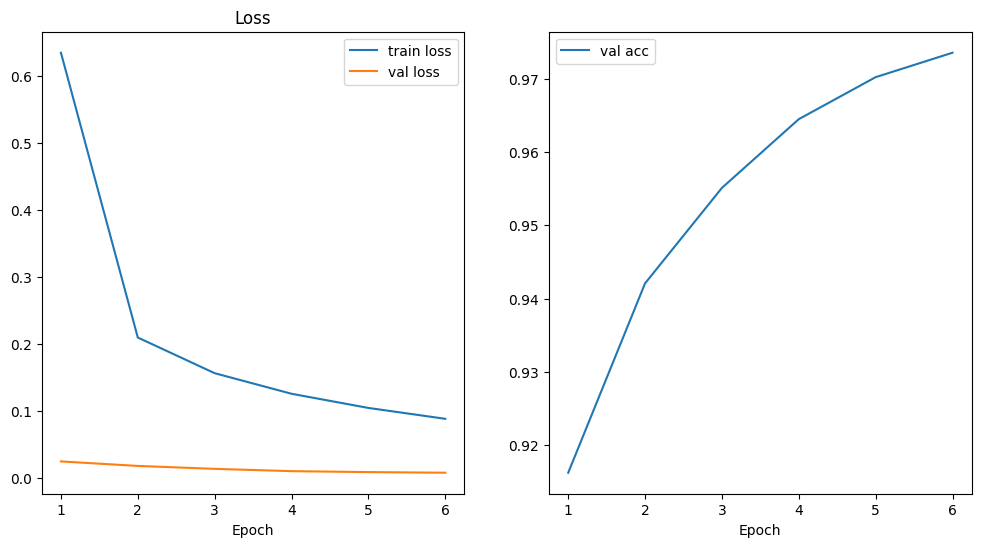

In [147]:
# plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history["train_loss"])+1), history["train_loss"], label="train loss")
plt.plot(range(1, len(history["train_loss"])+1), history["val_loss"], label="val loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.subplot(1, 2, 2)
# plt.plot(range(1, len(history)+1), history["train_acc"], label="train acc")
plt.plot(range(1, len(history["train_loss"])+1), history["val_acc"], label="val acc")
plt.legend()
plt.xlabel("Epoch")

### Q15

In [106]:
model.parameters()

<generator object Module.parameters at 0x7f4ed040d900>

In [109]:
model =Model()
# get number of trainable parameters
params1 = sum(p.numel() for p in model.parameters())# if p.requires_grad)
params2 = sum(p.numel() for p in multi_model.parameters())# if p.requires_grad)

Text(0, 0.5, 'Number of Parameters')

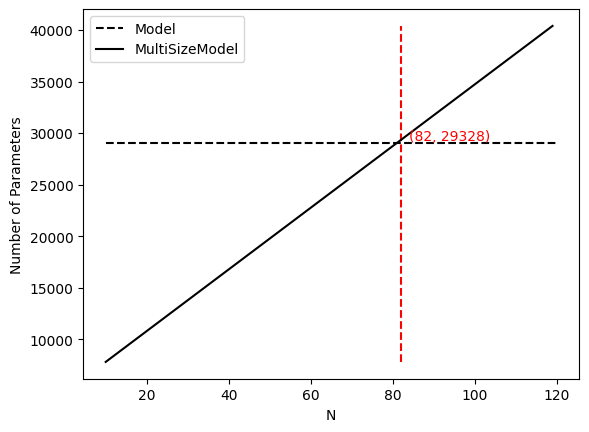

In [133]:
#plot horizontal line for number of parameters dashed line
rr = [10, 120, 1]
plt.hlines(params1, rr[0], rr[1], label="Model", linestyles="dashed", colors="black")
rng = range(*rr)
params2 =[sum(p.numel() for p in MultiModel(N).parameters()) for N in rng]
for i in range(len(params2)):
    if params2[i] > params1:
        plt.vlines(rng[i], params2[0], params2[-1], linestyles="dashed", colors="red")
        plt.text(rng[i]+2, params2[i], f"({rng[i]}, {params2[i]})", color="red")
        break
    
plt.plot(rng, params2, label="MultiSizeModel", c="black")
plt.xlabel("N")
plt.legend()
plt.ylabel("Number of Parameters")

In [163]:
co = nn.Conv2d(3, 16, 5, padding=1, stride=2)

In [166]:
inp = torch.randn(1, 3, 1024, 768)
inp = torch.randn(1, 3, 1920, 1080)

In [167]:
co(inp).shape

torch.Size([1, 16, 959, 539])